In [4]:
import sqlalchemy as db
from db_services import *
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objects as go
import json

In [5]:
def get_album_artist(album_soup):

    try:
        artist = album_soup.find(string=' by ').parent.find(class_='contributor').find('a')
        return artist.text
    except:
        return ''
    
ai = []
albums = {}
try:
    with open('albums.json','r') as f:
        albums = json.load(f)
except:
    pass




if len(albums)==0:
    conn,engine = get_connection()
    corpus = conn.execute(db.select(rank.c.url,webpage.c.name,webpage.c.text,webpage.c.pagetype,webpage.c.html).join(webpage,rank.c.url==webpage.c.url).where(db.or_(webpage.c.pagetype=='album',webpage.c.pagetype=='artist')).order_by(rank.c.rank.desc())).fetchall()

    print(len(corpus))
    conn.close()

    for i in range(len(corpus)):
        corp = corpus[i]
        if corp[3]=='album':
            soup = BeautifulSoup(corp[4],'html.parser')
            artist = get_album_artist(soup)
        
            albums[corp[1]] = artist
            ai.append(i)

    with open('albums.json','w') as f:
        json.dump(albums,f)

        

5948


3330
Feature names 
['00' '000' '01' ... 'zorn' 'ö3' 'ørsted'] 2000


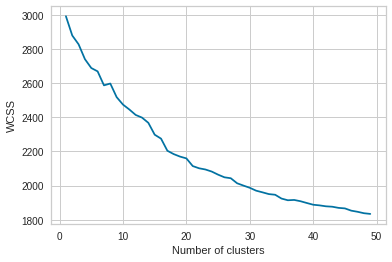

0
0.9045992493629456


In [6]:
def album():
    conn,engine = get_connection()
    #corpus = conn.execute(db.select(connectedpages.c.url,webpage.c.name,webpage.c.html).join(webpage,connectedpages.c.url==webpage.c.url)).fetchall()
    corpus = conn.execute(db.select(rank.c.url,webpage.c.name,webpage.c.text,webpage.c.pagetype,webpage.c.html).join(webpage,rank.c.url==webpage.c.url).where(webpage.c.pagetype=='album').order_by(rank.c.rank.desc())).fetchall()

    print(len(corpus))
    conn.close()
    text_corp = []
    for corp in corpus:
        text_corp.append(corp[2].replace('\n',' ').replace('\t',' '))
    vectorizer = TfidfVectorizer(max_features=2000,stop_words='english',min_df =.025,max_df=.975)
    vectors = vectorizer.fit_transform(text_corp)
    feature_names = vectorizer.get_feature_names_out()
    print(f'Feature names \n{feature_names}', len(feature_names))
    matrix = vectors.todense()
    list_dense=matrix.tolist()
    df = pd.DataFrame(list_dense,columns=feature_names)
    d = euclidean_distances(vectors)

    wcss = [] 
    for i in range(1, 50): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(df) 
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 50), wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') 
    plt.show()

    j = 0
    js = []
    labels = []
    for i in range(len(corpus)):
        if(d[i].mean() > 1.4):
            j+=1
            print(i,d[i].mean(),corpus[i][1])
            js.append(i)
        else:
            if(corpus[i][3]=='album'):
                album_name = corpus[i][1]
                artist = albums[album_name]
                if(artist!=''):
                    astring = ': '+artist
                else:
                    astring = ''
                labels.append(album_name+astring)
            else:
                labels.append(corpus[i][1])
    print(j)


    df2 = df.drop(df.index[js])

    kmeans = KMeans(n_clusters=42,random_state=42)
    kmeans.fit(df2)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(df2)
    print(tsne.kl_divergence_)

    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1],hover_name=labels,color=kmeans.labels_)
    fig.update_layout(
        title=f"t-SNE reduction of {len(df2)} TF-IDF measured Wikipedia articles on Jazz albums",

    )
    fig.update(layout_coloraxis_showscale=False)
    #py.plot(fig,filename='jazz-albums-42',auto_open=True)

    fig.show()

album()
    

In [7]:
def pie_artist():
    conn,engine = get_connection()
    #corpus = conn.execute(db.select(connectedpages.c.url,webpage.c.name,webpage.c.html).join(webpage,connectedpages.c.url==webpage.c.url)).fetchall()
    corpus = conn.execute(db.select(rank.c.url,webpage.c.name,webpage.c.pagetype,rank.c.rank).join(webpage,rank.c.url==webpage.c.url).where(webpage.c.pagetype=='artist').order_by(rank.c.rank.desc())).fetchall()

    print(len(corpus))
    conn.close()
    data = []
    for corp in corpus:
        if(corp[3]>100):
            data.append((corp[1],corp[3]))

    cutoff = 45

    data = data[:min(cutoff,len(data))]

    L = len(data)
    
    df = pd.DataFrame(data,columns=['artist','rank'])



    fig = go.Figure(data=[go.Pie(labels=df['artist'],values=df['rank'],hole=.3
    )])
    fig.update_layout(
        title=f"Number of links to top {cutoff} Jazz artist pages from {56773} Wikipedia articles on Jazz",

    )
    fig.update_traces(textinfo='label+value',hoverinfo='percent')

    fig.show()

pie_artist()
    

2618
